# Facility Location Problem

You can run a cell either by clicking `Run` on the toolbar or by pressing `CTRL+RETURN`. Pressing `SHIFT+RETURN` will run the cell and move the pointer to the next one. For a complete list of keyboard shortcuts press `H`.

## Introduction

In this Jupyter notebook we are going to model the facility location problem together. As usual, we will use visualizations extencively to make sure that you can easily follow the process. Visualizations are expecially useful when working with geographical problems, since you can, for example, plot the solution on a map and introduce the solution to your colleagues or to the public in an accessible manner (the Political Districting Problem is a great example).  
Now, let us define the problem in its most basic form.

Suppose there are $n$ facilities and $m$ customers. To simplify the writing, we let $I= \{1, \ldots, n\}$ and $J=\{1, \ldots, m\}$. All facilities and all customers have their predefined locations. Our aim is to satisfy the customers' demand $d_j$, $j \in J$ while minimizing the costs. We want to answer the following questions:
1. Which facilities do we need to open?
2. Which opened facility will supply which customer(s)?

Opening a facility costs $f_i, i \in I$ and transporting a unit of commodity from the facility $i$ to the customer $j$ costs $c_{ij}$, $i \in I$, $j \in J$.  
As we progress in this notebook, we will add further complications to this model.

Run the cell below to import all the necessary libraries. In this case we import `Gurobi` and `matplotlib`. The second library will be used for plotting a couple of graphs later.

In [1]:
from gurobipy import *
import matplotlib.pyplot as plt
import numpy as np

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Data

Below you will find the data supplied by your professor/manager/friend/etc.  
The following data is available to you:  
`f_locations`: a list containing the locations of the facilities (x, y)  
`f`: a list containing the costs of opening costs of the facilities  
`c_locations`: a list containing the locations of the customers (x, y)  
`d`: a list containing the demands the of the customers  
`n`: the number of facilities  
`m`: the number of customers  
`facilities`: for your convenience, a list of facility "names"; in our case $\{0,\ldots,n-1\}$  
`customers`: for your convenience, a list of customer "names"; in our case $\{0,\ldots,m-1\}$  
`c`: a list containing the transportation costs, computed using Manhattan distances

In [2]:
f_locations = [(10, 3), (12, 13), (3, 5), (1, 8), (7, 6)]
f = [60, 90, 80, 100, 30]
c_locations = [(13, 5), (15, 15), (3, 4), (3, 8), (5, 10), (14, 2), (6, 11), (13, 11), (9, 2), (11, 4)]
d = [10, 53, 23, 40, 11, 9, 90, 34, 35, 10]

assert len(f_locations) == len(f), 'Check the lists of facilities and opening costs'
assert len(c_locations) == len(d), 'Check the lists of customers and their demands'

n = len(f)
m = len(d)

facilities = range(n)
customers = range(m)

c = dict()
for i in facilities:
    for j in customers:
        loc_f_x, loc_f_y = f_locations[i]
        loc_c_x, loc_c_y = c_locations[j]
        c[i,j] = abs(loc_f_x - loc_c_x) + abs(loc_f_y - loc_c_y)

## Model

We start off by creating an empty model `m`.<br>
Reference: [Model()](https://www.gurobi.com/documentation/9.0/refman/py_model2.html)

In [3]:
model = Model('facility_location')

Using license file /Users/hhk/gurobi.lic
Academic license - for non-commercial use only


Then we add the necessary variables.  
In our case, we will need $n \times m$ integer variables. The variables, let us call them $x_{ij}$, $i \in I$, $j\in J$, will depict the number of units supplied by the facility $i$ to the customer $j$. Additionally, we define binary variables $y_i$, $i\in I$ reflecting whether the facility $i$ is open or not.  
Reference: [addVars()](https://www.gurobi.com/documentation/9.0/refman/py_model_addvars.html)

In [4]:
x = model.addVars(n, m, vtype=GRB.INTEGER, name='x')
y = model.addVars(m, vtype=GRB.BINARY, name='y')

Now, before we can start constructing our model, we need to formulate the objective function and the constraints "on paper".  
We want to minimize the total cost of the whole operation, i.e. the sum of opening and transportation costs. Hence, our objective function can be written as
$$min \sum_{i \in I}f_i y_i + \sum_{i \in I}\sum_{j \in J} c_{ij}x_{ij}$$
We will use the efficient function `quicksum()` provided in the `Gurobi` library.<br>
Reference: [setObjective()](https://www.gurobi.com/documentation/9.0/refman/py_model_setobjective.html), [quicksum()](https://www.gurobi.com/documentation/9.0/refman/py_quicksum.html)

In [5]:
model.setObjective(
    quicksum(f[i] * y[i] for i in facilities) +
    quicksum(c[i,j] * x[i,j] for i in facilities for j in customers)
)

It is time to add the demand constraints to our model. They may be written as
$$\sum_{i \in I} x_{ij} = d_j \quad \forall j \in J $$
meaning the combined supply of goods from all facitilites to a customer $j$ must cover their demand $d_i$.  
Also, do not forget to bind the variables, i.e., if we decide to transport goods from the facility $i$ to any customer, the facility $i$ *must* be opened:
$$x_{ij} \leq y_i*M \quad \forall i\in I \quad\forall j\in J$$
Reference: [addConstrs()](https://www.gurobi.com/documentation/9.0/refman/py_model_addconstrs.html)

In [6]:
model.addConstrs(quicksum(x[i,j] for i in facilities) == d[j] for j in customers)
model.addConstrs(x[i,j] <= y[i] * max(d) for i in facilities for j in customers)

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6): <gurobi.Constr *Awaiting Model Update*>,
 (1, 7): <gurobi.Constr *Awaiting Model Update*>,
 (1, 8): <gurobi.Constr *Awaiting Model Update*>,
 (1, 9): <gurobi.Constr *Awaiting Model Update*>,


We'll update and optimize our model.  
Reference: [update()](https://www.gurobi.com/documentation/9.0/refman/py_model_update.html), [optimize()](https://www.gurobi.com/documentation/9.0/refman/py_model_optimize.html)

In [7]:
model.update()
model.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 60 rows, 60 columns and 150 nonzeros
Model fingerprint: 0x1fac119d
Variable types: 0 continuous, 60 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 9e+01]
Found heuristic solution: objective 3055.0000000
Presolve removed 0 rows and 5 columns
Presolve time: 0.00s
Presolved: 60 rows, 55 columns, 150 nonzeros
Variable types: 0 continuous, 55 integer (5 binary)

Root relaxation: objective 1.561000e+03, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1561.0000000 1561.00000  0.00%     -    0s

Explored 0 nodes (15 simplex iterations) in 0.01 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 1561 3055 

Opt

We define a helper function for plotting our solutions. We can use it now and later to see the changes as we add more constraints.

In [8]:
def plot_result():
    plt.figure(figsize=(6, 6))
    
    for i in facilities:
        loc_x, loc_y = f_locations[i]
        plt.plot(loc_x, loc_y, markersize=4, color='r', marker='o')
        plt.text(loc_x, loc_y, i, fontsize=16, color='r')
    
    for j in customers:
        loc_x, loc_y = c_locations[j]
        plt.plot(loc_x, loc_y, markersize=4, color='g', marker='o')
        plt.text(loc_x, loc_y, j, fontsize=16, color='g')
        
    for i in facilities:
        for j in customers:
            if x[i,j].x > 0.5:
                loc_f_x, loc_f_y = f_locations[i]
                loc_c_x, loc_c_y = c_locations[j]
                plt.plot((loc_f_x, loc_c_x), (loc_f_y, loc_c_y), lw=.8, color='k', ls='--')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

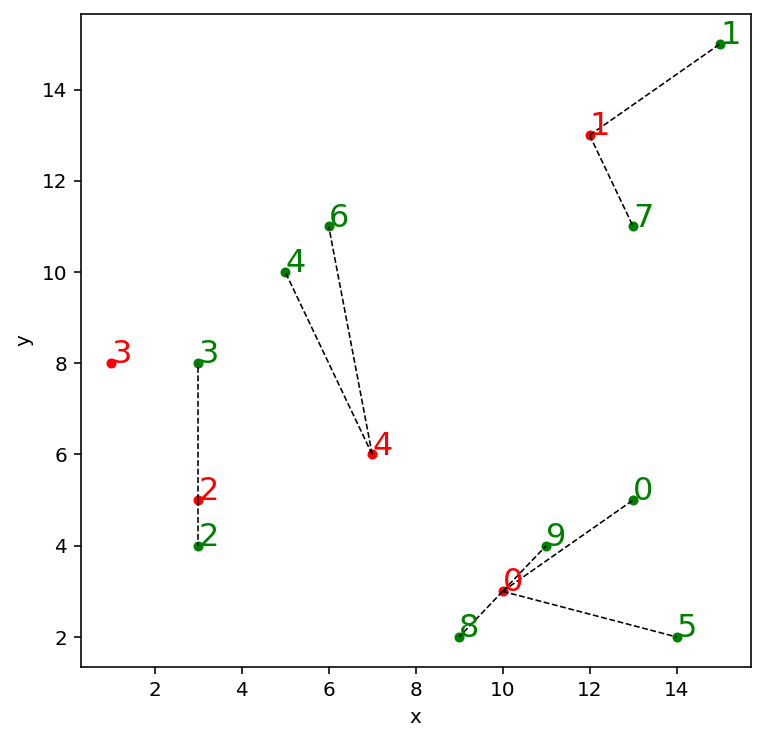

In [9]:
plot_result()

Great! We see that all opened facilities serve the closest customers. Note that the facility 3 was not opened, even though it is closer to the customer 3 than the facility 2. The facility 3 stayed closed because opening it purely for customer 3 would lead to higher total costs, since the opening costs would overweigh the transporatation savings.  
As an exercise, we can calculate the exact difference in costs between the current solution and the one, where we decide to open the facility 3 for the customer 3.

In [10]:
print(f'Opening the facility 3 to serve the customer 3 would costs us an additional {-((c[2,3] - c[3, 3]) * d[3] - f[3])} EUR')

Opening the facility 3 to serve the customer 3 would costs us an additional 60 EUR


## Complications

Now, we will perform modifications to our model and see how the allocation changes.

*Additional constraints*: In the real world, facilities most likely will not be able to supply infinite amounts of goods due to a finite inventory. From now on facilities can supply at most $u_i$, $i \in I$ units of commodity. The inventories of the facilities are specified in the next cell.

In [11]:
u = [55, 97, 40, 110, 100]

These constraints can be modelled as
$$\sum_{j \in J} x_{ij} \leq u_i \quad \forall i \in I$$

In [12]:
model.addConstrs(quicksum(x[i,j] for j in customers) <= u[i] for i in facilities)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>}

Run the optimization

In [13]:
model.update()
model.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 65 rows, 60 columns and 200 nonzeros
Model fingerprint: 0x85e318be
Variable types: 0 continuous, 60 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 1e+02]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint R60 by 9.000000000

Found heuristic solution: objective 2302.0000000
Presolve removed 4 rows and 5 columns
Presolve time: 0.00s
Presolved: 61 rows, 55 columns, 194 nonzeros
Variable types: 0 continuous, 55 integer (5 binary)

Root relaxation: objective 1.619625e+03, 19 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1619.62500    0    6 2302.00000 1619.62500  29.6%     -    0s

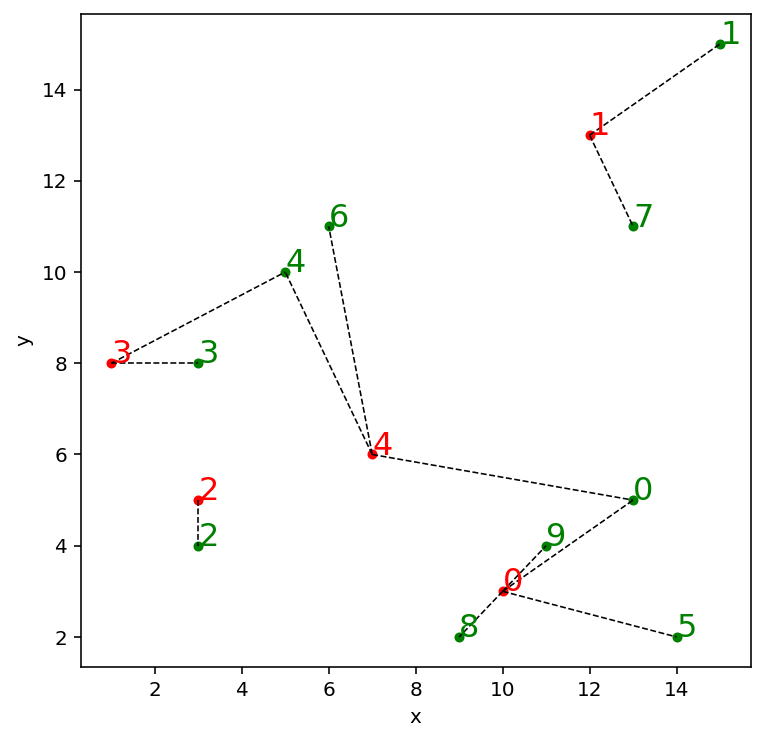

In [14]:
plot_result()

Note that the facility 3 needed to open now, since the low capacity of the facility 2 was not enough to keep supplying both customers 2 and 3. Also, it is pretty interesting to see that the facility 4 now also supplies the customer 0, because the capacity of the facility 0 is no longer sufficient (previously it could supply infinite goods, obviously).

*Modified objective function*: To avoid opening many facilities thus complicating the logistics and the management part of the operation, in addition to minimizing the costs, we now want ot punish facilities that have a total supply of less than 75% of their capacity $u_i$, $i \in I$. Such facilities will be punished by 50 EUR flat.  
To model this, we need a new binary variable $z_i$, $i \in I$, which tells us whether the facility $i$ works to the near full capacity, i.e., at least 75% of its capacity is utilized.  
We can model this variable as follows:
$$0.75u_i z_i \leq  \sum_{j \in J} x_{ij} \quad \forall i \in I$$

In [15]:
z = model.addVars(n, vtype=GRB.BINARY, name='z')
model.addConstrs(0.75 * u[i] * z[i] <= quicksum(x[i,j] for j in customers) for i in facilities)

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>}

The new objective function would now look like this:
$$min \sum_{i \in I}(f_i y_i + 50*(1-z_i) + \sum_{j \in J} c_{ij}x_{ij})$$

In [16]:
model.setObjective(
    quicksum(f[i] * y[i] for i in facilities) +
    quicksum(50 * (1 - z[i]) for i in facilities) +
    quicksum(c[i,j] * x[i,j] for i in facilities for j in customers)
)

In [17]:
model.update()
model.optimize()

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (mac64)
Optimize a model with 70 rows, 65 columns and 255 nonzeros
Model fingerprint: 0x7b810b6b
Variable types: 0 continuous, 65 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+00, 1e+02]

MIP start from previous solve produced solution with objective 1739 (0.00s)
Loaded MIP start from previous solve with objective 1739

Presolve removed 4 rows and 5 columns
Presolve time: 0.00s
Presolved: 66 rows, 60 columns, 249 nonzeros
Variable types: 0 continuous, 60 integer (10 binary)

Root relaxation: objective 1.649745e+03, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1649.74548    0    7 1739.00000 1649.74548  5.13%     -    0s
H    0     0                    1713.0000000 1649.7454

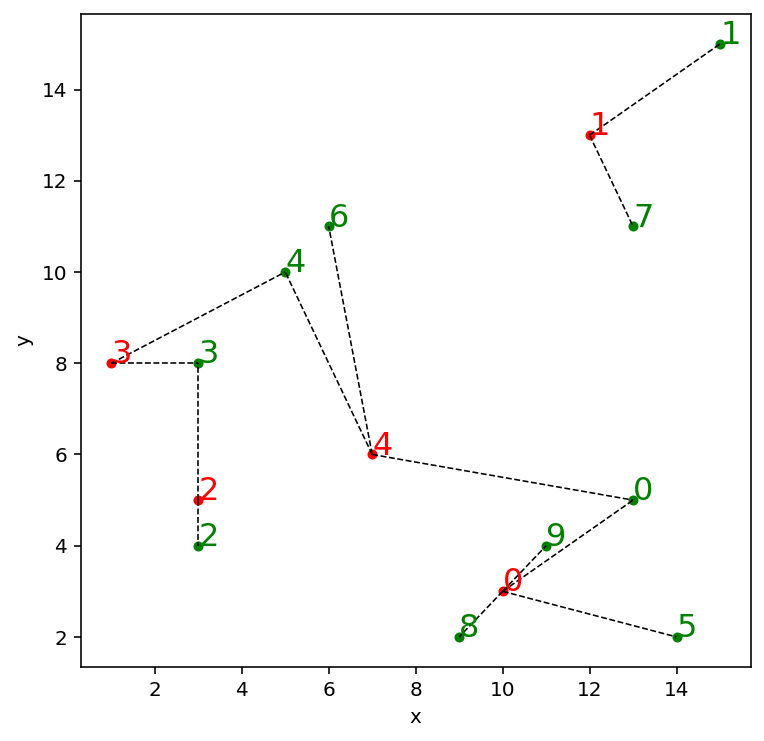

In [18]:
plot_result()

You can see how this change in the objective function forces the facility 2 to start supplying the customer 3, because otherwise it would be punished for underutilization of resources.

## Conclusion

In this notebook we have worked on the facility location problem and its slight variations. You have seen that, similarly to constraints, the objective function also has a direct impact on the solution. Once again, we've used simple graphs to observe the influence of the constraints and the objective function on the optimal solution.  
We hope you had fun today. Until next time!